# Linear Regression

Simple 1D linear regression

In [ ]:
from collections import namedtuple

Model = namedtuple('Model', ['w', 'b', 'dw', 'db', 'loss'])
State = namedtuple('State', ['loss', 'dw', 'db'])

In [17]:
class LinearRegression:
    def __init__(self, xs_train=1, ys_train=1, w=0, b=0, learning_rate=0.001, batch_size=None):
        self.m = len(xs_train)
        self.xs_train, self.ys_train = xs_train, ys_train
        self.w, self.b = w, b
        self.learning_rate = learning_rate
        
        self.batch_size = self.m if not batch_size else batch_size
        self.batch_index = 0 # The index into the training data of the next batch
        
    def forward_backward_prop(self, w=None, b=None):
        """Perform forward and backward prop over a minibatch
        
        Returns loss and gradients
        
        """
        w = self.w if not w else w
        b = self.b if not b else b
        
        loss = dw = db = 0
        lower, upper = self.batch_index*self.batch_size, (self.batch_index+1)*self.batch_size
        for x, y in zip(self.xs_train[lower:upper], self.ys_train[lower:upper]):
            # Forward Pass
            y_hat = w*x + b

            # Accumulate loss
            loss += 0.5 * (y_hat-y)**2

            # Backpropagate to accumulate dw and db
            dloss = 1
            dy_hat = (y_hat-y) * dloss
            db += dy_hat
            dw += x * dy_hat
        
        return State(loss/self.m, dw/self.m, db/self.m)
    
    def step(self):
        """Run one iteration of gradient descent with a minibatch"""
        
        loss, dw, db = self.forward_backward_prop()
        
        self.w -= self.learning_rate*dw
        self.b -= self.learning_rate*db
        
        # Update batch index so the next time the next batch in line is used
        self.batch_index = (self.batch_index+1) % (self.m//self.batch_size)
                
        return Model(self.w, self.b, dw, db, loss)

## Create Synthetic Data

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


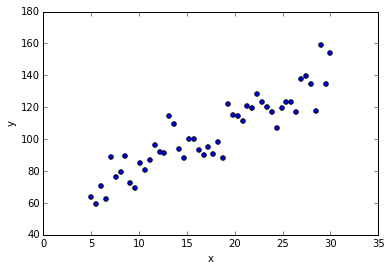

In [7]:
m = 50

xs_train = np.linspace(5, 30, num=m)
w_true, b = np.array([3.0]), 50

# Compute ys
noise_level = 10
ys_train = w_true[0]*xs_train + b
ys_train = np.array([y + np.random.randn()*noise_level for y in ys_train])

pd.DataFrame({'x': xs_train, 'y': ys_train}).plot(kind='scatter', x='x', y='y')

## Visualize the Model

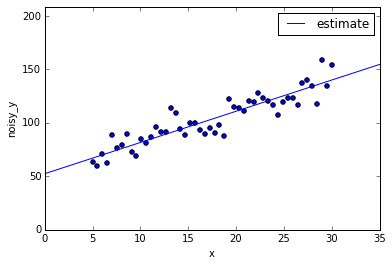

In [8]:
from ipywidgets import interact, fixed

lr = LinearRegression(xs_train, ys_train, batch_size=10)
def estimates(iters):
    for _ in range(iters):
        yield lr.step()
    
estimates = list(estimates(150000))

@interact(xs_train=fixed(xs_train), ys_train=fixed(ys_train), view_index=(0, len(estimates)), estimates=fixed(estimates))
def plot(xs_train, ys_train, view_index, estimates):
    w, b, _, _, _ = estimates[view_index]
    
    xs = np.linspace(0, 50)
    
    # Get data into suitable form for plotting
    df1 = pd.DataFrame({'x': xs_train, 'noisy_y': ys_train})
    df2 = pd.DataFrame({'x': xs, 'estimate': w*xs + b})
    
    # Plot
    axes = df1.plot(kind='scatter', x='x', y='noisy_y')
    axes = df2.plot(ax=axes, x='x', y='estimate')
    
    axes.set_ylim(0,max(ys_train)+50)
    axes.set_xlim(0,max(xs_train)+5)

## Finite Difference Gradient Check

In [13]:
def numerical_gradients(f, w, b):
    """Compute numerical gradients of f with respect to w and b
    
    Returns approximation for df/dw and df/db
    
    """
    h = 0.00001
    
    dw = (f(w+h, b)-f(w-h, b)) / (2*h)
    db = (f(w, b+h)-f(w, b-h)) / (2*h)
    
    return dw, db 

## Run Through a Few Iterations and Assert Analytic and Numerical Gradients are Close

In [16]:
lr = LinearRegression(xs_train, ys_train)

for _ in range(10):
    # Analytic gradient computed via backprop
    _, analytic_dw, analytic_db = lr.forward_backward_prop()
    
    # Numerical gradient compute via twiddling w and b and inspecting loss
    numerical_dw, numerical_db = numerical_gradients(lambda w, b: lr.forward_backward_prop(w, b).loss, lr.w, lr.b)
    
    # Compute relative error
    dw_error = abs(numerical_dw - analytic_dw) / (abs(numerical_dw) + abs(analytic_dw))
    db_error = abs(numerical_db - analytic_db) / (abs(numerical_db) + abs(analytic_db))
    
    try:
        assert(dw_error < 1e-6 and db_error < 1e-6)
    except AssertionError:
        warn(dw_error)
        warn(db_error)
        
else:
    print('Gradient check passed!')

Gradient check passed!
